# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in NumPy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [57]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    # Exercise f) - Additional activation functions
    def identity(self):
        """Identity activation: f(x) = x, f'(x) = 1"""
        return Var(self.v, lambda: [(self, 1.0)])
    
    def tanh(self):
        """Hyperbolic tangent: f(x) = tanh(x), f'(x) = 1 - tanh²(x)"""
        tanh_v = tanh(self.v)
        return Var(tanh_v, lambda: [(self, 1.0 - tanh_v ** 2)])
    
    def sigmoid(self):
        """Sigmoid: f(x) = 1/(1+exp(-x)), f'(x) = sigmoid(x)(1-sigmoid(x))"""
        sig_v = 1.0 / (1.0 + exp(-self.v))
        return Var(sig_v, lambda: [(self, sig_v * (1.0 - sig_v))])
    
    # Exercise k) - For cross-entropy loss
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [58]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [59]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

## Solution a)

The code computes the expression $f = a \cdot b + a \cdot d = a(b+d)$ with $a=3, b=5, d=9$, so $f = 3 \cdot (5+9) = 42$.

After calling `f.backward()`, the gradients are computed:
- `a.grad = ∂f/∂a = b + d = 14` (since f depends on a through both c and e)
- `b.grad = ∂f/∂b = a = 3`
- `c.grad = ∂f/∂c = 1` (intermediate node)
- `d.grad = ∂f/∂d = a = 3`
- `e.grad = ∂f/∂e = 1` (intermediate node)
- `f.grad = 1` (output node, df/df = 1)

We differentiate $f$ with respect to the input variables $a, b, d$.

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

## Solution b)

**1. Filled derivatives for the graphs:**

First graph (f = a * b):
- df/da = b = 5
- df/db = a = 3

Second graph (f = c + e, c = a*b, e = a*d):
- dc/da = b = 5
- dc/db = a = 3
- de/da = d = 9
- de/dd = a = 3
- df/dc = 1
- df/de = 1

**2. Data structure for first expression:**

When we execute `f = a * b`:
```
a: Var(v=3.0, grad=0.0, grad_fn=lambda: [])
b: Var(v=5.0, grad=0.0, grad_fn=lambda: [])
f: Var(v=15.0, grad=0.0, grad_fn=lambda: [(a, 5.0), (b, 3.0)])
```

**3. Backward execution by hand:**

Starting with `f.backward()` calls `f.backprop(1.0)`:
1. `f.grad += 1.0` → f.grad = 1.0
2. For (a, 5.0): `a.backprop(5.0 * 1.0)` → a.grad += 5.0
3. For (b, 3.0): `b.backprop(3.0 * 1.0)` → b.grad += 3.0

**4. Sequence of backprop calls:**

For second example:
1. `f.backprop(1.0)` → f.grad = 1.0
2. `c.backprop(1.0 * 1.0)` → c.grad = 1.0
3. `e.backprop(1.0 * 1.0)` → e.grad = 1.0
4. From c: `a.backprop(5.0 * 1.0)` → a.grad += 5.0
5. From c: `b.backprop(3.0 * 1.0)` → b.grad = 3.0
6. From e: `a.backprop(9.0 * 1.0)` → a.grad += 9.0 (total a.grad = 14.0)
7. From e: `d.backprop(3.0 * 1.0)` → d.grad = 3.0

In [60]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib
import networkx as nx
import matplotlib.pyplot as plt

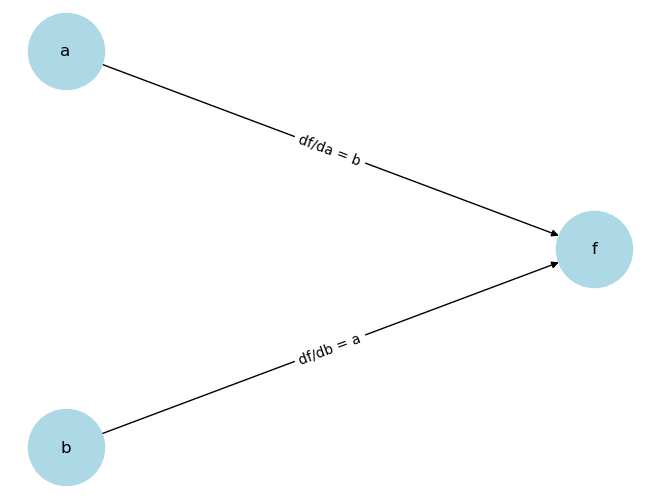

In [61]:
# Create a directed graph
G = nx.DiGraph()

# For expression f = a * b, the partial derivatives are:
# df/da = b
# df/db = a

# Add edges with labels
G.add_edge('a', 'f', label='df/da = b')
G.add_edge('b', 'f', label='df/db = a')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

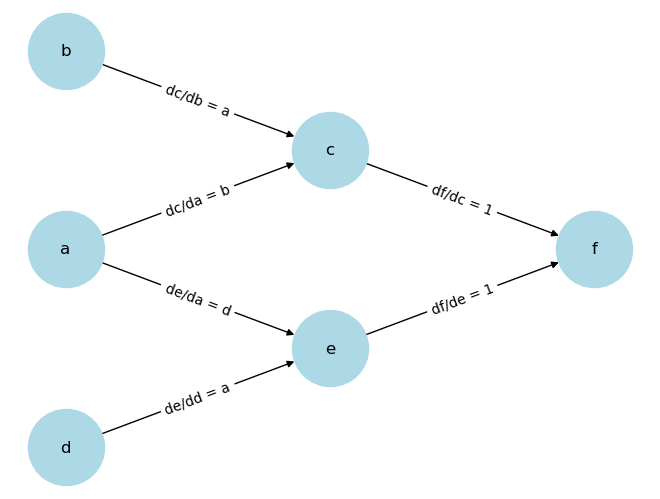

In [62]:
# Create a directed graph
G = nx.DiGraph()

# For expression:
# c = a * b  => dc/da = b, dc/db = a
# e = a * d  => de/da = d, de/dd = a
# f = c + e  => df/dc = 1, df/de = 1

# Add edges with labels
G.add_edge('a', 'c', label='dc/da = b')
G.add_edge('b', 'c', label='dc/db = a')
G.add_edge('a', 'e', label='de/da = d')
G.add_edge('d', 'e', label='de/dd = a')
G.add_edge('c', 'f', label='df/dc = 1')
G.add_edge('e', 'f', label='df/de = 1')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

## Solution c)

Running `f.backward()` again **accumulates** the gradients instead of resetting them. Each call to `backprop` uses `+=` to add to the existing gradient value.

So after running backward twice, all gradients are doubled:
- a.grad = 28 (was 14, now 14+14)
- b.grad = 6 (was 3, now 3+3)
- d.grad = 6 (was 3, now 3+3)
- etc.

This is useful for batch processing where we want to accumulate gradients over multiple examples before updating parameters.

In [63]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

## Solution d)

Calling `f.backprop(-1.0)` propagates a gradient of -1.0 backward instead of +1.0. Since gradients accumulate (using `+=`), this subtracts the gradients that were previously added.

If we had run `backward()` once (which calls `backprop(1.0)`), then running `backprop(-1.0)` will cancel out those gradients:
- Before: a.grad = 14
- After backprop(-1.0): a.grad = 14 + (-14) = 0

This effectively zeros the gradients, though it only works if backprop was called exactly once before. For general gradient zeroing, it's better to explicitly set `var.grad = 0.0` for all variables.

In [64]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [65]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Exercise e) - Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    # Evaluate f at a and a+da
    a_val = 3.0
    _, _, fa = f_function(a_val)
    _, _, fa_da = f_function(a_val + da)
    
    finite_difference = (fa_da.v - fa.v) / da
    
    return finite_difference

print("\nFinite difference test:")
print(f"Analytical gradient (from backprop): {f_function(3.0)[0].grad}")
print(f"Numerical gradient (finite difference): {finite_difference()}")
print(f"Difference: {abs(f_function(3.0)[0].grad - finite_difference())}")

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)

Finite difference test:
Analytical gradient (from backprop): 5.0
Numerical gradient (finite difference): 5.000000413701855
Difference: 4.1370185499545187e-07


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [67]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [68]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

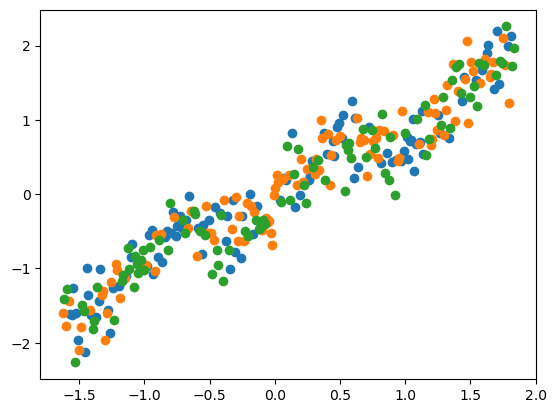

In [69]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [70]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [71]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [72]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [73]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # Exercise g) - Complete the forward pass
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]  # Start with bias term
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j] * single_input[i]  # Accumulate weighted inputs
            node = self.act_fn(node)  # Apply activation function
            out.append(node)

        return out

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [74]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0006, grad=0.0000)], [Var(v=0.0013, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=-0.0069, grad=0.0000)], [Var(v=0.0009, grad=0.0000)], [Var(v=0.0009, grad=0.0000)], [Var(v=0.0006, grad=0.0000)], [Var(v=-0.0017, grad=0.0000)], [Var(v=-0.0071, grad=0.0000)], [Var(v=0.0003, grad=0.0000)], [Var(v=0.0010, grad=0.0000)], [Var(v=-0.0044, grad=0.0000)], [Var(v=0.0008, grad=0.0000)], [Var(v=-0.0050, grad=0.0000)], [Var(v=0.0004, grad=0.0000)], [Var(v=0.0008, grad=0.0000)], [Var(v=0.0015, grad=0.0000)], [Var(v=0.0007, grad=0.0000)], [Var(v=0.0001, grad=0.0000)], [Var(v=0.0002, grad=0.0000)], [Var(v=-0.0033, grad=0.0000)], [Var(v=-0.0014, grad=0.0000)], [Var(v=0.0011, grad=0.0000)], [Var(v=0.0011, grad=0.0000)], [Var(v=-0.0019, grad=0.0000)], [Var(v=-0.0052, grad=0.0000)], [Var(v=0.0014, grad=0.0000)], [Var(v=0.0016, grad=0.0000)], [Var(v=0.0002, grad=0.0000)], [Var(v=0.0010, grad=0.0000)], [Var(v=-0.0065, grad=0.0000)], [Var(v=0.0002, grad=0.0000)], [Var(v=-0.0056, grad=0.0000)]

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [75]:
# Exercise h) - Print all network parameters

def print_network_parameters(network):
    """Print all parameters of the network with layer information."""
    for layer_idx, layer in enumerate(network):
        print(f"\n=== Layer {layer_idx} ===")
        print(f"Weights shape: {len(layer.weights)} x {len(layer.weights[0])}")
        print(f"Bias shape: {len(layer.bias)}")
        print("\nWeights:")
        for i, weight_row in enumerate(layer.weights):
            print(f"  Input {i}: {weight_row}")
        print("\nBiases:")
        print(f"  {layer.bias}")
        
# Test it
print_network_parameters(NN)


=== Layer 0 ===
Weights shape: 1 x 5
Bias shape: 5

Weights:
  Input 0: [Var(v=-0.1573, grad=0.0000), Var(v=-0.0247, grad=0.0000), Var(v=0.0394, grad=0.0000), Var(v=-0.0930, grad=0.0000), Var(v=-0.1053, grad=0.0000)]

Biases:
  [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]

=== Layer 1 ===
Weights shape: 5 x 1
Bias shape: 1

Weights:
  Input 0: [Var(v=0.0321, grad=0.0000)]
  Input 1: [Var(v=0.0697, grad=0.0000)]
  Input 2: [Var(v=0.0222, grad=0.0000)]
  Input 3: [Var(v=0.0616, grad=0.0000)]
  Input 4: [Var(v=-0.1617, grad=0.0000)]

Biases:
  [Var(v=0.0000, grad=0.0000)]


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

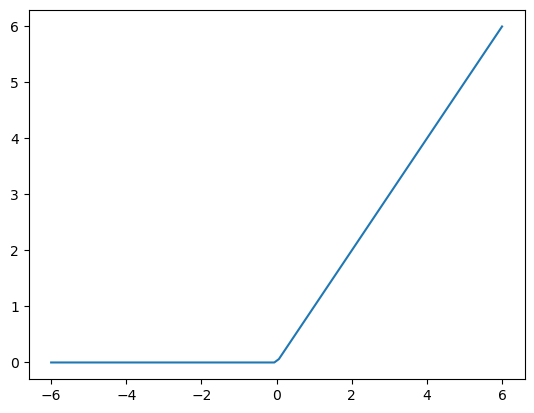

In [76]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

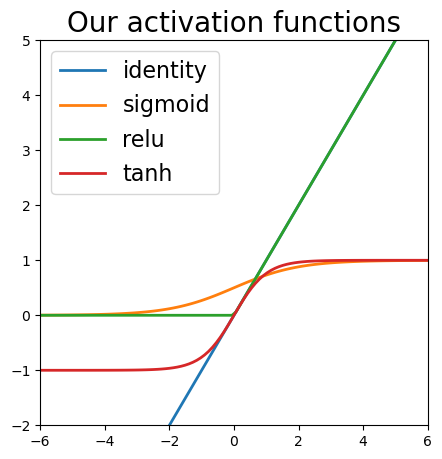

In [77]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [78]:
# Exercise i) - Glorot and He initialization
import math

## Glorot (Xavier) initialization
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  # For tanh activation, alpha = 1
  # std = sqrt(2 * alpha / (n_in + n_out)) = sqrt(2 / (n_in + n_out))
  std = math.sqrt(2.0 / (n_in + n_out))
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(0.0, std))

def DenseLayer_Glorot_relu(n_in: int, n_out: int):
  # For relu activation with Glorot, alpha = 2
  # std = sqrt(2 * alpha / (n_in + n_out)) = sqrt(4 / (n_in + n_out))
  std = math.sqrt(4.0 / (n_in + n_out))
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(0.0, std))

## He initialization
def DenseLayer_He_relu(n_in: int, n_out: int):
  # For relu activation, alpha = 2
  # std = sqrt(alpha / n_in) = sqrt(2 / n_in)
  std = math.sqrt(2.0 / n_in)
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(0.0, std))

# To test numerically: 
# 1. Create a deep network with many layers
# 2. Forward propagate random inputs through the network
# 3. Compute variance of activations at each layer
# 4. Plot variance vs layer depth - should remain approximately constant
# 5. Compare with poorly initialized network (e.g., constant std) where variance explodes or vanishes

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [79]:
# Exercise j) - Forward pass unit test

# Create a simple 2-2-1 network with all weights = 1, bias = 0, identity activation
test_network = [
    DenseLayer(2, 2, lambda x: x.identity(), initializer=ConstantInitializer(1.0, 0.0)),
    DenseLayer(2, 1, lambda x: x.identity(), initializer=ConstantInitializer(1.0, 0.0))
]

# Input: [1, 2]
test_input = nparray_to_Var(np.array([[1.0, 2.0]]))

# Expected output:
# Layer 1: node_0 = 1*1 + 1*2 = 3, node_1 = 1*1 + 1*2 = 3
# Layer 2: output = 1*3 + 1*3 = 6
expected_output = 6.0

# Forward pass
test_output = forward(test_input, test_network)
actual_output = test_output[0][0].v

print(f"Expected output: {expected_output}")
print(f"Actual output: {actual_output}")

assert abs(actual_output - expected_output) < 1e-6, f"Forward pass test failed! Expected {expected_output}, got {actual_output}"
print("✓ Forward pass unit test passed!")

Expected output: 6.0
Actual output: 6.0
✓ Forward pass unit test passed!


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [80]:
def squared_loss(t, y):
  
  # add check that sizes agree
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [81]:
# Exercise k) - Implement cross entropy loss
def cross_entropy_loss(t, h):
    """
    Cross-entropy loss with LogSumExp for numerical stability.
    
    Args:
        t: target (one-hot encoded) - list of lists
        h: logits (pre-softmax outputs) - list of lists
    
    Returns:
        Loss: Var containing the total loss
    """
    
    def cross_entropy_single(t, h):
        """Compute loss for a single example."""
        # Loss = -sum_i(t_i * h_i) + LogSumExp(h)
        
        # First term: -sum(t_i * h_i)
        term1 = Var(0.0)
        for i in range(len(t)):
            term1 -= t[i] * h[i]
        
        # Second term: LogSumExp(h) = log(sum(exp(h_i)))
        sum_exp = Var(0.0)
        for i in range(len(h)):
            sum_exp += h[i].exp()
        term2 = sum_exp.log()
        
        return term1 + term2
    
    # Sum over all examples
    Loss = Var(0.0)
    for n in range(len(t)):
        Loss += cross_entropy_single(t[n], h[n])
    
    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [82]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [83]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.0130, grad=0.2712), Var(v=-0.0574, grad=-4.5202), Var(v=0.2870, grad=8.7557), Var(v=-0.0436, grad=-17.8996), Var(v=0.0124, grad=7.1626)]] Biases: [Var(v=0.0000, grad=-0.2466), Var(v=0.0000, grad=4.1094), Var(v=0.0000, grad=7.5174), Var(v=0.0000, grad=16.2730), Var(v=0.0000, grad=6.1497)]
Layer 1 
 Weights: [[Var(v=-0.0028, grad=1.2664)], [Var(v=0.0466, grad=5.5753)], [Var(v=-0.0839, grad=-29.9437)], [Var(v=0.1844, grad=4.2289)], [Var(v=-0.0687, grad=-1.2969)]] Biases: [Var(v=0.0000, grad=-1.3215)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [84]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [85]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=-0.0536, grad=0.2411), Var(v=-0.1717, grad=-2.3313), Var(v=0.1155, grad=-2.5845), Var(v=-0.0623, grad=1.9632), Var(v=0.0538, grad=-2.6349), Var(v=-0.1709, grad=-7.7018), Var(v=0.0440, grad=3.5095), Var(v=0.2737, grad=4.5899), Var(v=0.0665, grad=-6.5255), Var(v=0.0652, grad=5.1942), Var(v=0.1105, grad=-3.2217), Var(v=-0.1689, grad=-1.5437), Var(v=0.0751, grad=-8.8094), Var(v=0.1138, grad=-9.7619), Var(v=-0.0539, grad=6.4269)]] Biases: [Var(v=0.0000, grad=-0.2192), Var(v=0.0000, grad=2.1197), Var(v=0.0000, grad=-2.2206), Var(v=0.0000, grad=-1.7850), Var(v=0.0000, grad=-2.2640), Var(v=0.0000, grad=7.0024), Var(v=0.0000, grad=3.0154), Var(v=0.0000, grad=3.9437), Var(v=0.0000, grad=-5.6068), Var(v=0.0000, grad=4.4630), Var(v=0.0000, grad=-2.7681), Var(v=0.0000, grad=1.4035), Var(v=0.0000, grad=-7.5692), Var(v=0.0000, grad=-8.3876), Var(v=0.0000, grad=-5.8433)]
Layer 1 
 Weights: [[Var(v=-0.0071, grad=0.3797), Var(v=-0.0077, grad=-0.0388), Va

[None, None, None]

In [86]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [87]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [88]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 101.568 	 Validation loss: 101.642
  10 ( 5.00%) Train loss: 29.136 	 Validation loss: 27.190
  10 ( 5.00%) Train loss: 29.136 	 Validation loss: 27.190
  20 (10.00%) Train loss: 15.634 	 Validation loss: 13.402
  20 (10.00%) Train loss: 15.634 	 Validation loss: 13.402
  30 (15.00%) Train loss: 14.698 	 Validation loss: 11.861
  30 (15.00%) Train loss: 14.698 	 Validation loss: 11.861
  40 (20.00%) Train loss: 14.133 	 Validation loss: 11.065
  40 (20.00%) Train loss: 14.133 	 Validation loss: 11.065
  50 (25.00%) Train loss: 13.640 	 Validation loss: 10.494
  50 (25.00%) Train loss: 13.640 	 Validation loss: 10.494
  60 (30.00%) Train loss: 13.211 	 Validation loss: 10.104
  60 (30.00%) Train loss: 13.211 	 Validation loss: 10.104
  70 (35.00%) Train loss: 12.886 	 Validation loss: 9.776
  70 (35.00%) Train loss: 12.886 	 Validation loss: 9.776
  80 (40.00%) Train loss: 12.624 	 Validation loss: 9.536
  80 (40.00%) Train loss: 12.624 	 Validation loss: 9.536

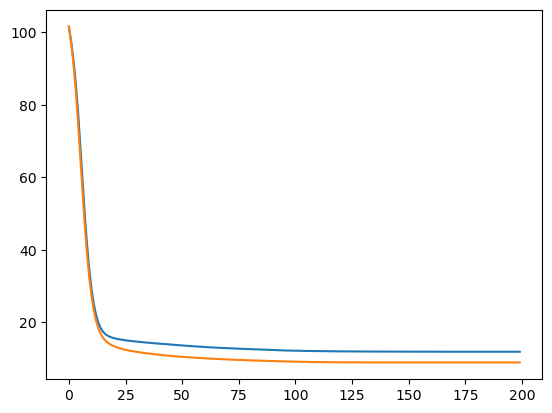

In [89]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [90]:
output_test = forward(x_test, NN)

Test loss:  9.797


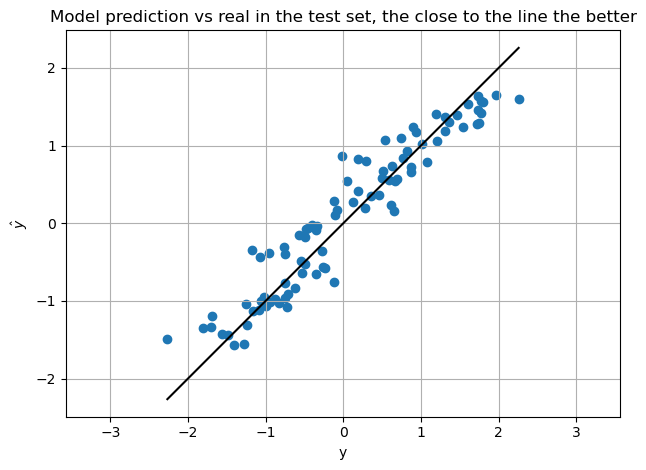

In [91]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

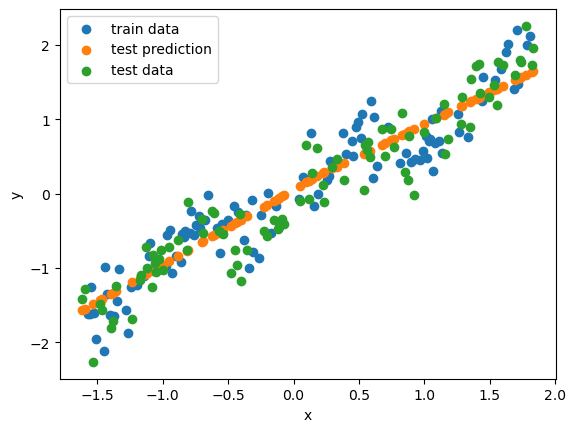

In [92]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._


## Solution l)

**Observations:**

1. **Underfitting (2 hidden units):** Both training and validation losses remain high. The model is too simple to capture the underlying patterns in the data.

2. **Overfitting (50-50-50 architecture):** Training loss becomes very low, but validation loss remains high or even increases. The model memorizes the training data but doesn't generalize well.

3. **Good fit (8 hidden units):** Both training and validation losses are low and track each other closely. The model captures the underlying patterns without memorizing noise.

**Validation vs Test:**
- For this problem, validation and test losses are typically similar because both are drawn from the same distribution.
- Validation/test separation is crucial when:
  - Tuning hyperparameters (learning rate, architecture, etc.) - use validation for this
  - Final unbiased performance estimate - use test only once at the end
  - Preventing "information leakage" from test set into model selection
  - In competitions/research where test labels are hidden

In [ ]:
# Exercise l) - Demonstrate overfitting, underfitting, and good fit

# 1. UNDERFITTING: Too simple model (1 hidden layer with 2 units)
print("=" * 50)
print("UNDERFITTING EXAMPLE")
print("=" * 50)

NN_underfit = [
    DenseLayer(1, 2, lambda x: x.relu()),
    DenseLayer(2, 1, lambda x: x.identity())
]

EPOCHS = 200
LEARN_R = 2e-3

train_loss_under = []
val_loss_under = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train, forward(x_train, NN_underfit))
    Loss.backward()
    update_parameters(parameters(NN_underfit), LEARN_R)
    zero_gradients(parameters(NN_underfit))
    
    train_loss_under.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_underfit))
    val_loss_under.append(Loss_validation.v)
    
    if e % 50 == 0:
        print(f"{e:4d} Train: {train_loss_under[-1]:4.3f} \t Val: {val_loss_under[-1]:4.3f}")

print(f"\nFinal - Train: {train_loss_under[-1]:4.3f} \t Val: {val_loss_under[-1]:4.3f}")
print("→ Both train and val loss are high (underfitting)\n")

# 2. OVERFITTING: Too complex model (many layers, many units)
print("=" * 50)
print("OVERFITTING EXAMPLE")
print("=" * 50)

NN_overfit = [
    DenseLayer(1, 50, lambda x: x.relu()),
    DenseLayer(50, 50, lambda x: x.relu()),
    DenseLayer(50, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

train_loss_over = []
val_loss_over = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train, forward(x_train, NN_overfit))
    Loss.backward()
    update_parameters(parameters(NN_overfit), LEARN_R)
    zero_gradients(parameters(NN_overfit))
    
    train_loss_over.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_overfit))
    val_loss_over.append(Loss_validation.v)
    
    if e % 50 == 0:
        print(f"{e:4d} Train: {train_loss_over[-1]:4.3f} \t Val: {val_loss_over[-1]:4.3f}")

print(f"\nFinal - Train: {train_loss_over[-1]:4.3f} \t Val: {val_loss_over[-1]:4.3f}")
print("→ Train loss << Val loss (overfitting)\n")

# 3. GOOD FIT: Balanced model
print("=" * 50)
print("GOOD FIT EXAMPLE")
print("=" * 50)

NN_good = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

train_loss_good = []
val_loss_good = []

for e in range(EPOCHS):
    Loss = squared_loss(y_train, forward(x_train, NN_good))
    Loss.backward()
    update_parameters(parameters(NN_good), LEARN_R)
    zero_gradients(parameters(NN_good))
    
    train_loss_good.append(Loss.v)
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN_good))
    val_loss_good.append(Loss_validation.v)
    
    if e % 50 == 0:
        print(f"{e:4d} Train: {train_loss_good[-1]:4.3f} \t Val: {val_loss_good[-1]:4.3f}")

print(f"\nFinal - Train: {train_loss_good[-1]:4.3f} \t Val: {val_loss_good[-1]:4.3f}")
print("→ Train and val loss both low and similar (good fit)\n")

# Plot comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss_under, label='Train')
plt.plot(val_loss_under, label='Val')
plt.title('Underfitting')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_loss_over, label='Train')
plt.plot(val_loss_over, label='Val')
plt.title('Overfitting')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(train_loss_good, label='Train')
plt.plot(val_loss_good, label='Val')
plt.title('Good Fit')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Exercise m) optional - Implement classification

# Generate simple classification dataset (XOR problem or simple 2D classification)
def generate_classification_data(n_samples=300):
    """Generate a simple 2-class classification dataset."""
    np.random.seed(42)
    
    # Create two blobs
    n_per_class = n_samples // 2
    
    # Class 0: centered around (-1, -1)
    X0 = np.random.randn(n_per_class, 2) * 0.5 + np.array([-1, -1])
    y0 = np.zeros((n_per_class, 2))
    y0[:, 0] = 1  # One-hot: [1, 0]
    
    # Class 1: centered around (1, 1)
    X1 = np.random.randn(n_per_class, 2) * 0.5 + np.array([1, 1])
    y1 = np.zeros((n_per_class, 2))
    y1[:, 1] = 1  # One-hot: [0, 1]
    
    # Combine and shuffle
    X = np.vstack([X0, X1])
    y = np.vstack([y0, y1])
    
    indices = np.random.permutation(n_samples)
    X = X[indices]
    y = y[indices]
    
    # Split into train/val/test
    train_idx = int(0.6 * n_samples)
    val_idx = int(0.8 * n_samples)
    
    X_train, y_train = X[:train_idx], y[:train_idx]
    X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
    X_test, y_test = X[val_idx:], y[val_idx:]
    
    # Convert to Var
    X_train = nparray_to_Var(X_train)
    y_train = nparray_to_Var(y_train)
    X_val = nparray_to_Var(X_val)
    y_val = nparray_to_Var(y_val)
    X_test = nparray_to_Var(X_test)
    y_test = nparray_to_Var(y_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Generate data
X_train_clf, y_train_clf, X_val_clf, y_val_clf, X_test_clf, y_test_clf = generate_classification_data(300)

# Define classification network (2 inputs -> hidden -> 2 outputs for 2 classes)
NN_clf = [
    DenseLayer(2, 10, lambda x: x.relu()),
    DenseLayer(10, 2, lambda x: x.identity())  # Output logits (pre-softmax)
]

# Training loop
EPOCHS_clf = 100
LEARN_R_clf = 1e-2

train_loss_clf = []
val_loss_clf = []

print("Training classification model...")
for e in range(EPOCHS_clf):
    # Forward pass
    logits_train = forward(X_train_clf, NN_clf)
    
    # Cross-entropy loss
    Loss = cross_entropy_loss(y_train_clf, logits_train)
    
    # Backward pass
    Loss.backward()
    
    # Update parameters
    update_parameters(parameters(NN_clf), LEARN_R_clf)
    zero_gradients(parameters(NN_clf))
    
    # Track losses
    train_loss_clf.append(Loss.v)
    
    # Validation loss
    logits_val = forward(X_val_clf, NN_clf)
    Loss_val = cross_entropy_loss(y_val_clf, logits_val)
    val_loss_clf.append(Loss_val.v)
    
    if e % 20 == 0:
        print(f"Epoch {e:3d}: Train Loss: {train_loss_clf[-1]:.4f}, Val Loss: {val_loss_clf[-1]:.4f}")

print(f"\nFinal: Train Loss: {train_loss_clf[-1]:.4f}, Val Loss: {val_loss_clf[-1]:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_clf, label='Train')
plt.plot(val_loss_clf, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.title('Classification Training')

# Compute accuracy
def compute_accuracy(y_true, logits):
    """Compute classification accuracy."""
    correct = 0
    total = len(y_true)
    
    for i in range(total):
        # Get predicted class (argmax of logits)
        pred_class = 0 if logits[i][0].v > logits[i][1].v else 1
        # Get true class (argmax of one-hot)
        true_class = 0 if y_true[i][0].v > y_true[i][1].v else 1
        
        if pred_class == true_class:
            correct += 1
    
    return correct / total

logits_test = forward(X_test_clf, NN_clf)
test_acc = compute_accuracy(y_test_clf, logits_test)
train_acc = compute_accuracy(y_train_clf, forward(X_train_clf, NN_clf))

print(f"\nTrain Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Visualize decision boundary
plt.subplot(1, 2, 2)
X_train_np = Var_to_nparray(X_train_clf)
y_train_np = Var_to_nparray(y_train_clf)
colors = ['red' if y[0] > 0.5 else 'blue' for y in y_train_np]
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=colors, alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Classification (Test Acc: {test_acc*100:.1f}%)')
plt.tight_layout()
plt.show()

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# Exercise n) optional - NeuralNetwork class

class NeuralNetwork:
    """A simple feedforward neural network class."""
    
    def __init__(self, layers):
        """
        Args:
            layers: List of DenseLayer objects
        """
        self.layers = layers
    
    def forward(self, input):
        """
        Forward pass through the network.
        
        Args:
            input: List of input examples (list of lists of Var)
        
        Returns:
            output: Network predictions (list of lists of Var)
        """
        def forward_single(x):
            for layer in self.layers:
                x = layer.forward(x)
            return x
        
        return [forward_single(input[n]) for n in range(len(input))]
    
    def parameters(self):
        """Get all parameters in the network."""
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params
    
    def update_parameters(self, learning_rate=0.01):
        """Update all parameters using gradient descent."""
        params = self.parameters()
        for p in params:
            p.v -= learning_rate * p.grad
    
    def zero_gradients(self):
        """Zero all parameter gradients."""
        params = self.parameters()
        for p in params:
            p.grad = 0.0
    
    def __repr__(self):
        """String representation of the network."""
        info = f"NeuralNetwork with {len(self.layers)} layers:\n"
        for i, layer in enumerate(self.layers):
            n_in = len(layer.weights)
            n_out = len(layer.weights[0])
            info += f"  Layer {i}: {n_in} -> {n_out}\n"
        return info
    
    def train_step(self, x_train, y_train, loss_fn, learning_rate=0.01):
        """
        Perform one training step.
        
        Args:
            x_train: Training inputs
            y_train: Training targets
            loss_fn: Loss function (e.g., squared_loss or cross_entropy_loss)
            learning_rate: Learning rate for gradient descent
        
        Returns:
            loss_value: The loss value for this step
        """
        # Forward pass
        predictions = self.forward(x_train)
        
        # Compute loss
        loss = loss_fn(y_train, predictions)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        self.update_parameters(learning_rate)
        
        # Zero gradients
        self.zero_gradients()
        
        return loss.v
    
    def fit(self, x_train, y_train, x_val, y_val, loss_fn, epochs=100, learning_rate=0.01, verbose=True):
        """
        Train the network.
        
        Args:
            x_train: Training inputs
            y_train: Training targets
            x_val: Validation inputs
            y_val: Validation targets
            loss_fn: Loss function
            epochs: Number of training epochs
            learning_rate: Learning rate
            verbose: Whether to print progress
        
        Returns:
            train_losses, val_losses: Lists of losses during training
        """
        train_losses = []
        val_losses = []
        
        for e in range(epochs):
            # Training step
            train_loss = self.train_step(x_train, y_train, loss_fn, learning_rate)
            train_losses.append(train_loss)
            
            # Validation loss
            val_pred = self.forward(x_val)
            val_loss = loss_fn(y_val, val_pred).v
            val_losses.append(val_loss)
            
            if verbose and e % (epochs // 10) == 0:
                print(f"Epoch {e:4d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if verbose:
            print(f"Final: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        return train_losses, val_losses

# Example usage:
print("Creating network using NeuralNetwork class...")
nn = NeuralNetwork([
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
])

print(nn)

print("\nTraining with NeuralNetwork class...")
train_losses, val_losses = nn.fit(
    x_train, y_train, 
    x_validation, y_validation,
    squared_loss,
    epochs=100,
    learning_rate=2e-3,
    verbose=True
)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training with NeuralNetwork Class')
plt.show()

# Test on test set
test_pred = nn.forward(x_test)
test_loss = squared_loss(y_test, test_pred).v
print(f"\nTest Loss: {test_loss:.4f}")